## Units

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import imageio.v2 as io
from PIL import Image

In [2]:
from tensorflow.keras.layers import Conv2D, Input, Concatenate, Activation, MaxPool2D, UpSampling2D, GroupNormalization, \
                                    Add, Multiply
from tensorflow.keras.models import Model


## Definitons:

In [5]:
def conv(x, filters:int=8, activation:str="swish"):
    for i in range(2):
        x = Conv2D(filters, (3,3), padding='same')(x)
        x = GroupNormalization(groups=-1)(x) # InstanceNorm
        x = Activation(activation)(x)
    return x

In [6]:
def unet(filters=8, layers=4, input_shape=(224,224,1), activation='swish'):
    to_concat = []
    
    model_in = Input(input_shape)
    x = model_in
    
    # Encoder
    for i in range(layers):
        x = conv(x, filters*2**i, activation)
        to_concat.append(x)
        x = MaxPool2D()(x)
    
    # Latent
    x = Conv2D(filters*2**layers, (3,3), padding='same')(x)
    x = GroupNormalization(groups=-1)(x)  # InstanceNorm
    x = Activation(activation)(x)
    
    # Decoder
    for i in range(layers):
        x = UpSampling2D()(x)
        x = Concatenate()([x, to_concat.pop()])
        x = conv(x, filters*2**(layers-i-1), activation)
    
    x = Conv2D(1, (1,1), padding='same')(x)
    model_out = Activation("sigmoid")(x)
    
    return Model(model_in, model_out)

In [7]:
def nested_unet(nests=4, filters=1, forward_input=True, operation="multiply", input_shape=(256, 256, 1)):
    x = Input(input_shape)
    m0 = unet(filters, input_shape=input_shape)(x)
    
    if nests > 1:
        tmp = m0
        
        for i in range(nests-1):
            if forward_input:
                if operation == 'add':
                    tmp = Add()([x, tmp])
                    
                elif operation == 'multiply':
                    tmp = Multiply()([x, tmp])
                    
                else:
                    tmp = Concatenate(axis=3)([x, tmp])
                
            tmp = unet(filters, input_shape=tmp.shape[1:])(tmp)

        return Model(x, tmp)        
        
    else:
        return Model(x, m0)

In [8]:
def read_dataset(folder_path: str, num_ims: int, size: tuple = None, is_training: bool = False, randomize: bool = True, validation_split: float = 0.2) -> tuple:
    output = []
    image_paths = [folder_path + str(i) + ".png" for i in range(num_ims)]
    
    if is_training:
        mask_paths = [folder_path + str(i) + "_seg.png" for i in range(num_ims)]
        masks = []

        for i in range(num_ims):
            mask = io.imread(mask_paths[i])

            if np.max(mask) != 0:
                if np.max(mask) > 10:
                    mask = mask / 255.0

                img = Image.open(image_paths[i]).convert("L")  # Open image in grayscale

                if size is not None:
                    img = np.array(img.resize(size))
                    mask = np.array(Image.fromarray(mask).resize(size))

                output.append(np.array(tf.expand_dims(img, -1)))
                masks.append(np.array(tf.expand_dims(mask, -1)))

        if randomize:
            # Randomizing
            n_samples = len(output)
            np.random.seed(42)
            indices = np.arange(n_samples)
            np.random.shuffle(indices)

            output = [output[i] for i in indices]
            masks = [masks[i] for i in indices]

        # Split into training and validation sets
        split_index = int(len(output) * (1 - validation_split))
        train_output, val_output = output[:split_index], output[split_index:]
        train_masks, val_masks = masks[:split_index], masks[split_index:]

        return (train_output, train_masks), (val_output, val_masks)
    else:
        for i in range(len(image_paths)):
            img = Image.open(image_paths[i]).convert("L")  # Open image in grayscale

            if size is not None:
                img = np.array(img.resize(size))

            output.append(np.array(tf.expand_dims(img, -1)))

        return output

## Training:

In [6]:
TRAINING_PATH = "./training224x224/"
image_width = 224
image_height = 224
NUM_NESTS = 4 # 1, 2, 4, 8, 16
NUM_FILTERS = 8 # 16
OPERATION = "multiply" # "add", "multiply", "concatenate"
   
N = 22 # arbitrary number of samples

train_imgs = [TRAINING_PATH + str(i) + ".png" for i in range(N)]
train_segs = [TRAINING_PATH + str(i) + "_seg.png" for i in range(N)]

imgs = []
segs = []

for i in range(N):
    seg = io.imread(train_segs[i])
    if np.max(seg) != 0:  # To remove the black images
        if np.max(seg) > 10:
            seg = seg / 255.0

        img = io.imread(train_imgs[i]) / 255.0

        imgs.append(np.array(tf.expand_dims(img, -1))) # imgs.append(np.expand_dims(img, axis=2))
        segs.append(np.array(tf.expand_dims(seg, -1))) # segs.append(np.expand_dims(seg, axis=2))

# Randomizing
n_samples = len(imgs)
np.random.seed(42)
indices = np.arange(n_samples)
np.random.shuffle(indices)  # Shuffling indices directly

imgs = [imgs[i] for i in indices]
segs = [segs[i] for i in indices]


plt.imshow(imgs[0], cmap = 'gray')


In [8]:
nested_model = nested_unet(nests=NUM_NESTS, filters=NUM_FILTERS, operation=OPERATION, input_shape=(image_width, image_height, 1))

nested_model.summary()
nested_model.compile("adam", "mse")

# Training
history = nested_model.fit(np.array(imgs), np.array(segs), epochs=10, batch_size=4)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 model (Functional)          (None, 224, 224, 1)          344625    ['input_1[0][0]']             
                                                                                                  
 multiply (Multiply)         (None, 224, 224, 1)          0         ['input_1[0][0]',             
                                                                     'model[0][0]']               
                                                                                                  
 model_1 (Functional)        (None, 224, 224, 1)          344625    ['multiply[0][0]']      

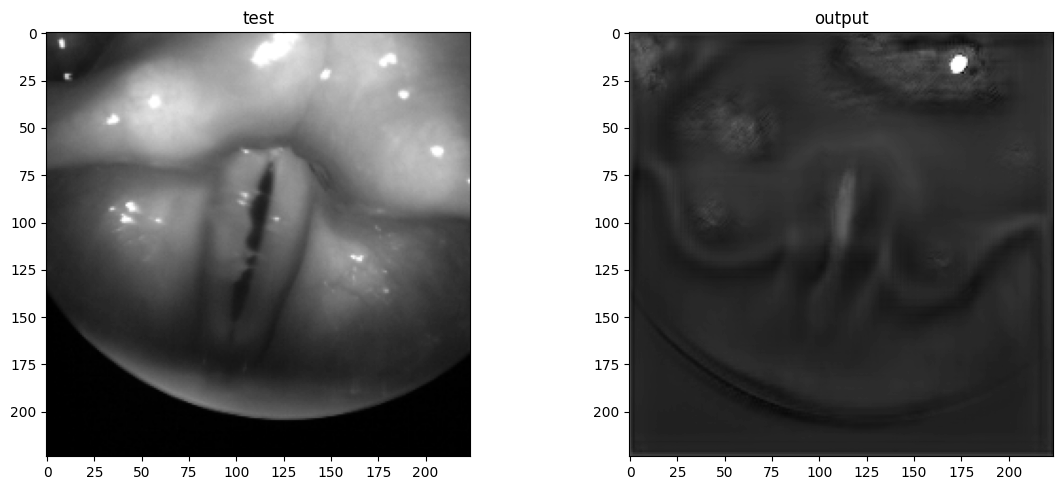

In [14]:
tests = []
test_imgs = [TRAINING_PATH + str(i) + ".png" for i in range(N+1,N+10)]
for i in range(len(test_imgs)):
    img = io.imread(test_imgs[i]) / 255.0
    tests.append(np.array(tf.expand_dims(img, -1)))
    
# predicting:
pred = nested_model.predict(np.array(tests))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(tests[0], cmap='gray'); plt.title('test')
plt.subplot(1,2,2); plt.imshow(pred[0], cmap='gray'); plt.title('output')
plt.tight_layout() 

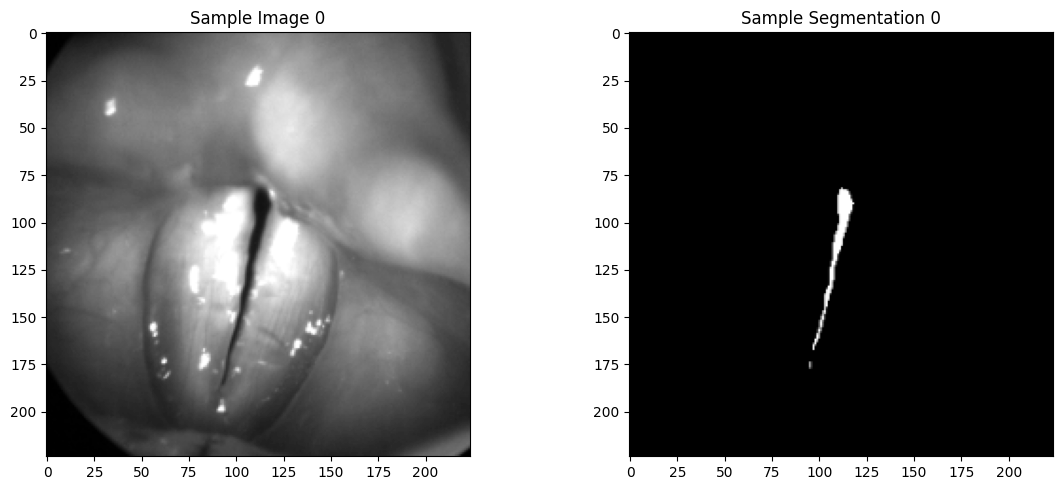

In [10]:
TRAINING_PATH = "./training224x224/"
image_width = 224
image_height = 224
num_nests = [1, 2, 4, 8, 16]
numFilters = [8, 16] 
operations = ["add", "multiply", "concatenate"]
N = 22 # arbitrary number of samples

train_data, val_data = read_dataset(folder_path = TRAINING_PATH, num_ims = N, is_training = True, randomize = True)
train_imgs, train_segs = train_data
val_imgs, val_segs = val_data
# show a random sample k 
k = 0
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(train_imgs[0], cmap='gray'); plt.title(f"Sample Image {k}")
plt.subplot(1,2,2); plt.imshow(train_segs[0], cmap='gray'); plt.title(f"Sample Segmentation {k}")
plt.tight_layout() 

In [ ]:
for current_num_nests in num_nests:
    for current_num_filters in numFilters:
        for current_operation in operations:
            
            nested_model = nested_unet(nests=current_num_nests, filters=current_num_filters, operation=current_operation, input_shape=(image_width, image_height, 1))
            nested_model.compile("adam", "mse")

            # Training
            
            history = nested_model.fit(np.array(train_data[0]), np.array(train_data[1]), epochs=10, batch_size=4)

            # Checkpoints
            nested_model.save(f"nestedUnet_{current_num_nests}_{current_num_filters}_{current_operation}.h5")

## Testing:

In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import imageio.v3 as io
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# plt.plot(history.history["iou_score"], label="training")
# plt.plot(history.history["val_iou_score"], label="validation")
# plt.xlabel("epochs")
# plt.ylabel("IoU")
# plt.show()

In [5]:
TRAINING_PATH = "./training224x224/"
model_path = "/data/xu21qori/BVM24/nestedUnet_4_16_multiply_1_final.keras"
trained_model = load_model(model_path)

In [17]:
N = int(55749*0.1)
tests = []
segs = []
test_imgs = [TRAINING_PATH + str(i) + ".png" for i in range(N+1,N+10)]
seg_imgs = [TRAINING_PATH + str(i) + "_seg.png" for i in range(N+1,N+10)]
for i in range(len(test_imgs)):
    img = io.imread(test_imgs[i]) / 255.0
    seg = io.imread(seg_imgs[i]) / 255.0
    tests.append(np.array(tf.expand_dims(img, -1)))
    segs.append(np.array(tf.expand_dims(seg, -1)))


2023-10-23 16:59:16.229316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-23 16:59:16.775423: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-10-23 16:59:16.776754: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-10-23 16:59:16.776765: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-10-23 16:59:16.776826: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-10-23 

1/1 [==============================] - 7s 7s/step


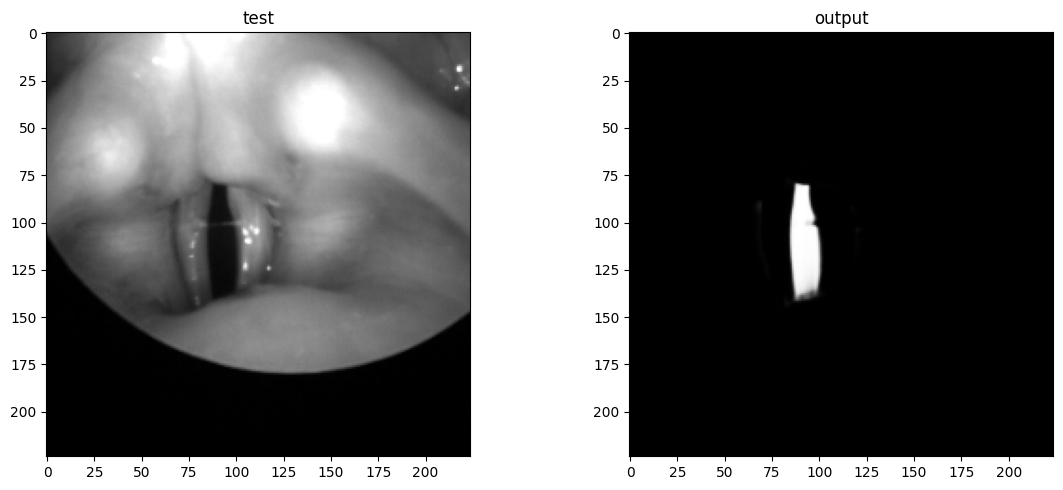

In [13]:
# predicting:
pred = trained_model.predict(np.array(tests))


In [19]:
from ipywidgets import interact, fixed
def showresults(tests, results, gts):
  @interact
  def showresults(x=(0,len(tests)-1)):
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1); plt.imshow(tests[x], cmap='gray'); plt.title(f"test number {N+x}")
    plt.subplot(1,3,2); plt.imshow(results[x], cmap='gray'); plt.title(f"output number {N+x} ")
    plt.subplot(1,3,3); plt.imshow(gts[x], cmap='gray'); plt.title(f"GT number {N+x} ")
    plt.tight_layout() 

In [20]:
showresults(tests, pred, segs)